In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from meerkat import ads, parser

### Setup ADS1115

In [2]:
dev = ads.ADS1115(bus_n=1)
dev.get_config()
dev.pga('6.144')  # Other options: '6.144', '4.096'
dev.mux('1G')     # pin 1 relative to ground
dev.get_config()  # refresh for measurements

### Print Status

In [3]:
dev.print_attributes()

ADS11x5 Configuration Attributes
--------------------------------
Config Register: 20736 0x5100 0b101000100000000
PGA Range: +/- 6.144 Volts
Mode: single
Data Rate: 8 SPS
Input Multiplexer: 1G
Comparator:
 Queue: 1
 Latching: off
 Polarity: Active 1
 Mode: trad


### Single Tests

In [4]:
print('Measured voltage: {}'.format(dev.voltage()))

Measured voltage: 0.9061875


In [5]:
print(dev.writer.create_metadata(indent=4))

#!{
    "accuracy": null,
    "bytes": null,
    "case_sensitive_header": false,
    "comment": "#",
    "delimiter": ",",
    "description": null,
    "device": {
        "accuracy": null,
        "active": null,
        "bus": "<meerkat.i2c_pi.WrapI2C object at 0x6e8a7830>",
        "calibration_date": null,
        "description": "Texas Instruments 16-bit 860SPS 4-Ch Delta-Sigma ADC with PGA",
        "dtype": null,
        "error": null,
        "manufacturer": "Texas Instruments",
        "name": "ADS1115",
        "pga_gain": -999,
        "precision": "16bit",
        "state": null,
        "urls": "www.ti.com/product/ADS1115",
        "version_hw": "1.0",
        "version_sw": "1.0"
    },
    "double_quote": true,
    "dtypes": null,
    "encoding": "utf-8",
    "escape_char": "\\",
    "format": null,
    "hash": null,
    "header": [
        "description",
        "sample_n",
        "mux",
        "voltage"
    ],
    "licenses": null,
    "line_terminator": "\n",
    "medi

In [6]:
print(dev.writer.header)

['description', 'sample_n', 'mux', 'voltage']


In [7]:
dev.get(description='ADS1115_example_1', n=5)

[['ADS1115_example_1', 1, 5, 2.0488125],
 ['ADS1115_example_1', 2, 5, 2.0488125],
 ['ADS1115_example_1', 3, 5, 2.0488125],
 ['ADS1115_example_1', 4, 5, 2.0488125],
 ['ADS1115_example_1', 5, 5, 2.0488125]]

### File Save Test
LM4040 2.048 V reference source connected to A0

In [8]:
dev.writer.path = 'ADS1115_example.csv'

In [9]:
dev.write(description='ADS1115_example_1', n=15)

In [10]:
m, df = parser.csv_resource(dev.writer.path)

In [11]:
df.head()

,std_time_ms,description,sample_n,mux,voltage,datetime64_ns
0,2019-03-16 12:14:02.759939,ADS1115_example_1,1,5,2.048812,2019-03-16 12:14:02.759939
1,2019-03-16 12:14:02.772230,ADS1115_example_1,2,5,2.048812,2019-03-16 12:14:02.772230
2,2019-03-16 12:14:02.788794,ADS1115_example_1,3,5,2.048812,2019-03-16 12:14:02.788794
3,2019-03-16 12:14:02.803814,ADS1115_example_1,4,5,2.048812,2019-03-16 12:14:02.803814
4,2019-03-16 12:14:02.815607,ADS1115_example_1,5,5,2.048812,2019-03-16 12:14:02.815607


In [12]:
df.dtypes

std_time_ms              object
description              object
sample_n                  int64
mux                       int64
voltage                 float64
datetime64_ns    datetime64[ns]
dtype: object

### Verify Timestamp Format

In [13]:
dev.writer.timepiece.format_used

'std_time_ms'

In [14]:
m['time_format'] == dev.writer.timepiece.format_used

True

### Plot Data

In [15]:
df['rolling_mean'] = df.voltage.rolling(4, win_type='triang').mean()

In [16]:
df_mean = df.voltage.mean()
df['mean'] = df_mean

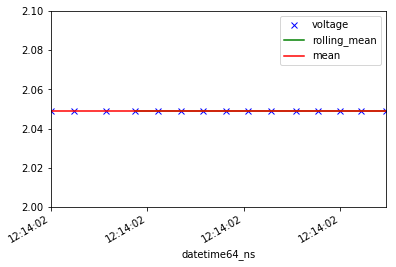

In [17]:
df.datetime64_ns = df.datetime64_ns.dt.tz_localize('UTC')  # Pandas 0.24.1 hack
df[['datetime64_ns', 'voltage',
    'rolling_mean', 'mean']].plot(x='datetime64_ns',
                                  style=[' xb', '-g', '-r'],
                                  ylim=(2.0, 2.1));

In [18]:
print('Mean: {:8.6} Volts DC'.format(df_mean))
print('Standard Deviation: {}'.format(df.voltage.std()))

Mean:  2.04881 Volts DC
Standard Deviation: 0.0


In [19]:
dt = df.datetime64_ns[len(df)-1]-df.datetime64_ns[0]
dtt = dt.seconds + dt.microseconds / 10**6
print('Sample Rate: {:.4f} Hz'.format(len(df)/dtt))

Sample Rate: 86.4942 Hz


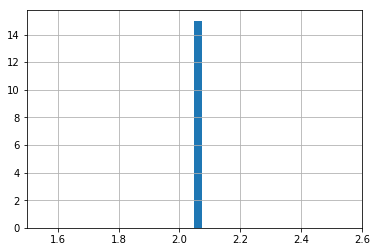

In [20]:
df.voltage.hist(bins=40);

In [21]:
dev.mode('continuous')
dev.get_config()
print('{:b}'.format(dev.config_value))
print(dev.mode_value)

1000000100000000
1


In [22]:
dev.mode('single')
dev.get_config()
print('{:b}'.format(dev.config_value))
print(dev.mode_value)

1000000100000000
1


In [23]:
bin(dev.config_value)

'0b1000000100000000'